# Ground-Borne Train Vibration Predictions in Valdemoro

In this notebook the code necessary for processing the field measurements performed in Valdemoro (date 17-12-2018) as part of the Transfer Mobility method for railway-induced ground-borne vibration predictions is explained. 
The notebook will be divided in the following manner:

Part 1: Characterization of train-track system (i.e. Obtaining FDL) <br>
Part 2: Making vibration predictions (i.e. Obtaining LSTM(d) and calculating L<sub>aw</sub>)

### Assumptions of the method
<ul>
<li>The theory of the method assumes that the force generated by the train is independent of local geological conditions (since we are using a FDL of one site, on another site where it might have created a different force).</li>
<li>Due to hardware limitations, we are considering only the vertical axis for acceleration measurements.</li>
<li>Due to practical limitations, the impact positions are not at the track centerline directly, we impacted at points as adjacent to the tracks as possible (fences...).</li>
</ul>

### Information about the measurements
<ul>
<li>Sampling frequency: 4096 Hz</li>
</ul>

In [1]:
## Importing packages
import imp 
import math
import numpy as np
import matplotlib.pyplot as plt
import librosa
import pandas
import xlrd
from scipy import integrate
from scipy import signal
from scipy.fftpack import fft
#Append the path to import "my module" from Modules
import sys
sys.path.insert(0, 'C:/Users/coordinador/Desktop/Jupyter Notebooks/Modules')

from mi_modulo import *

# PART 0: Data import

In [2]:
#GENERATE DATA FROM EXCEL FILES (obtained from BK Connect)

# data = import_and_crop_data(cropped_signal_samples = 4096, pre_force_samples = 50, pto = 99)
# np.save("all_signals_4096_samples_with_Pto1", data)

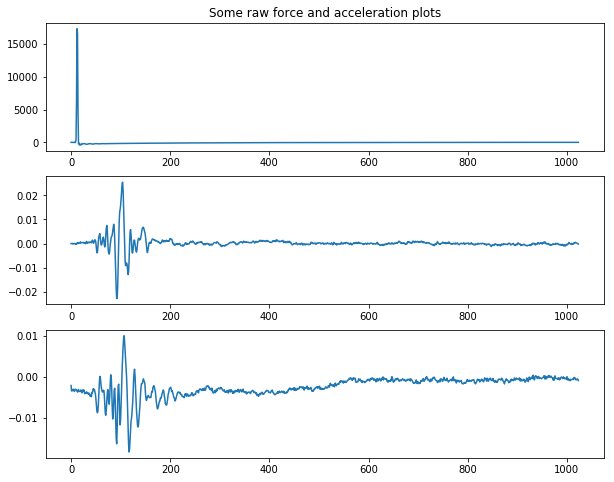

In [2]:
#LOAD DATA IF IT HAS BEEN ALREADY GENERATED

# data = np.load("all_signals_2000_samples_with_Pto1.npy")
# data = np.load("all_signals_2048_samples_with_Pto1.npy")
data = np.load("all_signals_4096_samples_with_Pto1.npy")

#RESAMPLING, to have same fs than in the measurements performed in Miranda de Ebro
fs = 1024
data = resample(data, orig_sr = 4096, target_sr = fs)

#CORRECTION OF AMPLITUDES of point1 (teníamos cambiada la sensibilidad de la maza por la del acelerómetro durante las medidas
# realizadas en el Punto 1 de medida)
#Correct force signals
data[:,0:20, 0] = data[:,0:20, 0] * 101.8 / 0.2604
#Correct accelerations of signal 3 
data[:,40:, 0] = data[:,40:, 0] * 0.2604 / 101.8

#Remove DC component
# for i in range(data.shape[2]):
#     for ii in range(data.shape[1]):
#         data[:,ii,i] = data[:,ii,i] - np.mean(data[:,ii,i])

#Create time vector
time_vector = np.arange(data.shape[0])

#Generate plot
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (10,8))
mean = np.mean(data[:,45,0])
ax1.set_title("Some raw force and acceleration plots")
ax1.plot(time_vector, data[:, 0, 0])
ax2.plot(time_vector, data[:, 20, 0])
# ax2.set_ylim([0,0.005])
ax3.plot(time_vector, data[:, 40, 0])


# PART 1: Characterization of train-track system 

The objective of this part is to obtain the FDL that characterizes the train-track vibration system. <br> Part 1 is subdivided in three steps:
-  Step A - Obtaining the Line Source Transfer Mobility <br>
-  Step B - Processing of acceleration levels L<sub>a</sub><br>
-  Step C - Obtaining the Force Density Level (FDL)<br>

## Step A - Obtaining the Line Source Transfer Mobility

The line source transfer mobility (LSTM) is obtained from several point source transfer mobilities (PSTMs) that were previously obtained through measurements of impact force along the railway line and measurements of acceleration response at certain accelerometer locations.


We impacted at 11 positions (in order to simulate the train as a line source), 20 times (for posterior averaging to improve SNR), and measured at 2 accelerometer positions. Therefore, we have: <br>
> 20 * 11 = 220 force signals <br> 20 * 11 * 2 = 440 acceleration signals

The 20 averages is a recommendation made by the developers of the method.


### Windows

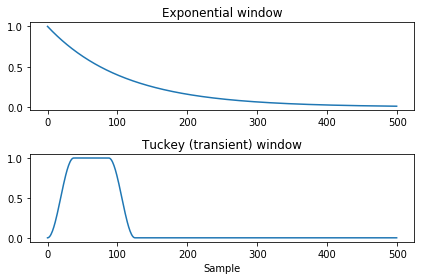

In [3]:
#Generate windows
window_exp, window_transient = get_windows(signal, M = data.shape[0], N = 125, alpha = 0.6)

#Generate plot
fig, (ax1, ax2) = plt.subplots(2, figsize = (6,4))
ax1.plot(window_exp)
ax2.plot(window_transient)
ax1.set_title("Exponential window")
ax2.set_title("Tuckey (transient) window")
ax2.set_xlabel("Sample")
plt.tight_layout()

In [5]:
#Apply windows to all signals (WE DID NOT USE WINDOWS IN THIS WORK)
# num_samples = data.shape[0]
# data = data * np.reshape(window_exp,(num_samples,1,1))

### Zero-padding the signals to avoid NaN values when converting to 3rd octave bands 

In [4]:
#Generate zeros and apply zero-padding
# amount_of_zero_padding = 1024 - data.shape[0]
# zeros = np.zeros((amount_of_zero_padding, 60, 11))
# data = np.concatenate((data,zeros), axis = 0)

### Frequency transformations of recorded signals

In [13]:
#Calculate FT of all signals, shape = (number of samples,60,11), type = complex
data_narrow_acc = calculate_fft_3D(data, fft)

#Calculate autospectra of all signals, shape = (2000,60,11)
Sxx_acc = calculate_autospectra_3D(data_narrow_acc)

#Calculate cross spectra of all signals, shape = (2000,40,11), type = complex
Sxy_acc = calculate_cross_spectra_3D(data_narrow_acc)

#Calculate averaged double sided cross and auto spectra, shape = (2000,3,11) and shape = (2000,2,11)
ASxx_acc, ASxy_acc = calculate_averages(Sxx_acc, Sxy_acc, number_of_avg = 20)

#Convert to single sided spectra, shaoe = (1000,3,11)
AGxx_acc = make_single_sided_3D(ASxx_acc)
AGxy_acc = make_single_sided_3D(ASxy_acc)

In [14]:
#Reference values for calculating decibels for all the following calculations
ref_acc  = 10 ** (-6)
ref_force = 1
ref_LSTM = ref_acc / ref_force
ref_FRF_acc = ref_acc

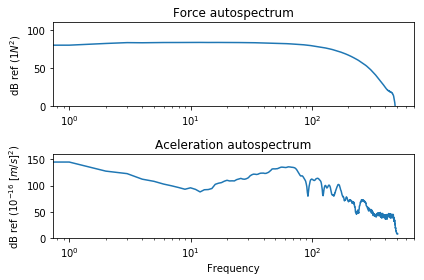

In [15]:
#Generate plots
fig, (ax1, ax2) = plt.subplots(2, figsize = (6,4))


nt = data.shape[0]
nf = nt
dt = 1 / fs
df = fs / nf 
freq_vector = np.arange(0, fs / 2, df)  #single sided 

ax1.plot(freq_vector, 10 * np.log(AGxx_acc[:,0,2] / ref_force ** 2))
ax2.plot(freq_vector, 10 * np.log(AGxx_acc[:,1,2] / ref_acc ** 2 ))

# ax1.plot(freq_vector, AGxx_acc[:,0,2] )
# ax2.plot(freq_vector, AGxy_acc[:,1,2] )

ax1.set_title("Force autospectrum")
ax1.set_xscale("log")
ax1.set_ylabel("dB ref ($1 N^2$)")
# ax1.set_xlim([1, fs/2])
ax1.set_ylim([0,110])
ax2.set_title("Aceleration autospectrum")
ax2.set_xlabel("Frequency")
ax2.set_xscale("log")
# ax2.set_xlim([1, fs/2])
ax2.set_ylim([0,160])
ax2.set_ylabel("dB ref ($10^{-16}$ $[m/s]^{2}$)")
plt.tight_layout()

### FRF and Coherence of recorded signals

In [16]:
#Number of frequency lines/bins
freq_bins = AGxx_acc.shape[0]

#Number of measurement points
meas_points = AGxx_acc.shape[-1]

#Calculate H1 frequency response function estimators, shapes = (1000,10)
Hxy_acc1_acc = AGxy_acc[:,0,:] / AGxx_acc[:,0,:]
Hxy_acc2_acc = AGxy_acc[:,1,:] / AGxx_acc[:,0,:]

#Stack them into two arrays of shapes (1000,10,2)
Hxy_acc = np.column_stack((np.reshape(Hxy_acc1_acc,(freq_bins,1,meas_points)),np.reshape(Hxy_acc2_acc,(freq_bins,1,meas_points))))

#Calculate coherence functions, shapes = (1000, 10)
gamma_xy_acc1_acc = np.divide(np.square(AGxy_acc[:,0,:]) , AGxx_acc[:,0,:] * AGxx_acc[:,1,:])
gamma_xy_acc2_acc = np.divide(np.square(AGxy_acc[:,1,:]) , AGxx_acc[:,0,:] * AGxx_acc[:,2,:])

(1, 200)

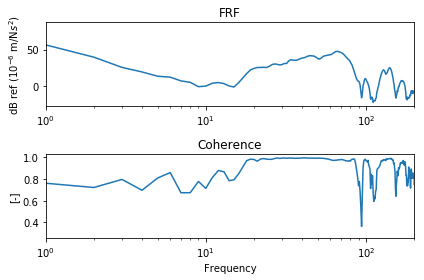

In [17]:
#Generate plot
fig, (ax1, ax2) = plt.subplots(2, figsize = (6,4))

ax1.plot(freq_vector, 20 * np.log(Hxy_acc1_acc[:,1] / ref_FRF_acc ))
ax2.plot(freq_vector, (gamma_xy_acc1_acc[:,1]))

ax1.set_title("FRF")
ax1.set_xscale("log")
ax1.set_ylabel("dB ref ($10^{-6}$ m/N$s^{2}$)")
ax2.set_title("Coherence")
ax2.set_xlabel("Frequency")
ax2.set_ylabel("[-]")
ax2.set_xscale("log")
plt.tight_layout()

ax1.set_xlim([1,200])
ax2.set_xlim([1,200])


### Line Source Transfer Mobility (LSTM)

In [18]:
# Third octave bands values
center_freq_3oct = [1, 1.25, 1.6, 2, 2.5, 3.15, 4, 5, 6.3, 8, 10, 12.5, 16, 20,   25, 31.5,   40,   50,   63,   80]
lowlim_freq_3oct = np.round(np.array(center_freq_3oct) / (2**(1/6)), decimals = 2)
uplim_freq_3oct = np.round(np.array(center_freq_3oct) * (2**(1/6)), decimals = 2)

In [19]:
#Point Source Transfer Mobilities (PSTMs) shapes = (1000,11) 
PSTMs_acc1_narrow = Hxy_acc1_acc  
PSTMs_acc2_narrow = Hxy_acc2_acc 
#Obtain LSTM through numerical integration of the different PSTMs. LSTMs shape = (1000,)
LSTM_acc1_narrow = PSTMs_to_LSTM(PSTMs_acc1_narrow , distance_interval = 4.6)
LSTM_acc2_narrow = PSTMs_to_LSTM(PSTMs_acc2_narrow , distance_interval = 4.6)
#Convert LSTM narrowband into third octave bands
LSTM_acc1_3oct, _, _ = narrow_to_third(LSTM_acc1_narrow, fs = fs)
LSTM_acc2_3oct, _, _ = narrow_to_third(LSTM_acc2_narrow, fs = fs)

Text(0.5,1,'Plot of an averaged PSTM of certain impact point')

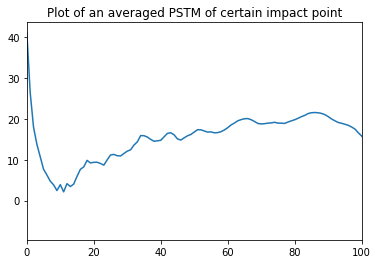

In [22]:
plt.plot(20 * np.log10(PSTMs_acc1_narrow[:,8] / ref_acc ))
plt.xlim([0,100])
plt.title("Plot of an averaged PSTM of certain impact point")

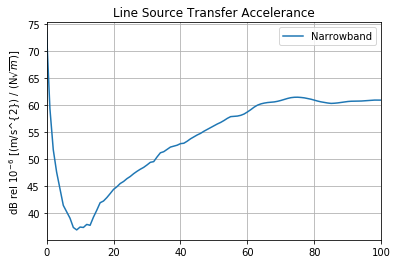

In [23]:
#Plot LSTM in narrowband and in third octave bands, for the first accelerometer
plt.figure(1)
plt.plot(freq_vector, 20 * np.log10(LSTM_acc1_narrow / ref_LSTM))
# plt.hlines(20 * np.log10(LSTM_acc1_3oct / ref_LSTM), lowlim_freq_3oct, uplim_freq_3oct)
plt.title("Line Source Transfer Accelerance")
plt.ylabel("dB rel $10^{-6}$ [(m/s^{2}) / (N$\sqrt{m}$)]")
plt.legend(["Narrowband", "Third octave"])
plt.xlim([0,100])
# plt.ylim([0,100])
plt.grid(b = True)


## Step B - Processing of acceleration levels L<sub>A</sub>


While the train is passing, the acceleration levels are measured at the same positions where the acceleration measurements for the calculation of the PSTMs were performed. 
We measured for as long as the train was in front of the measurement line. This is done in order to obtain the FDL. 
    
Important to note: In order to obtain the FDL accordingly to the requirements of the RD 1367/2007, we need to take the
aceleration levels of the 1s duration chunk of the acceleration signal, that presents the highest "aw" value, that is, 
after having performed a third-octave band weighting of the 1s chunk.

### Import acceleration data of some train

In [24]:
#Import acceleration data of some train recorded signal (2 accelerometers were used, acc1 and acc2)
_, train_acc1_res, train_acc2_res = train4_data_import("Tren4.xlsx")

fs = 1024
#Resample to 1024 Hz (to have same fs than in the Miranda measurements)
train_acc1_res = librosa.core.resample(train_acc1_res.astype(np.float), orig_sr = 4096, target_sr = fs)
train_acc2_res = librosa.core.resample(train_acc2_res.astype(np.float), orig_sr = 4096, target_sr = fs)

### Find the 1s duration chunk with the highest a<sub>w</sub>

The Law of this signal is 71.02 dB


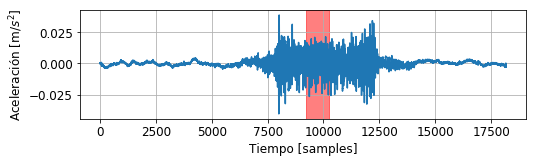

In [81]:

#Find the 1s duration chunk with highest rms value
start_sample, end_sample, chunk_ft_acc_values, chunk_signal, aw = obtain_greatest_rms_chunk(train_acc2_res, fft, fs = fs)

time_vector = np.arange(train_acc1_res.shape[0])

#Generate plot
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (8,2))
ax1.plot(time_vector, train_acc1_res)
ax1.set(xlabel = "Tiempo [samples]", ylabel = "Aceleración [m/$s^2$]")
ax1.grid(b=True)
#Mark in red the chunk with the highest rms value
ax1.axvspan(start_sample, end_sample, color='red', alpha=0.5)

Law = 20 * np.log10(aw / (10**(-6)))
print("The Law of this signal is" , np.round(Law,decimals=2), "dB")

### Calculate the acceleration levels  of that chunk

C:\Users\coordinador\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


(0, 100)

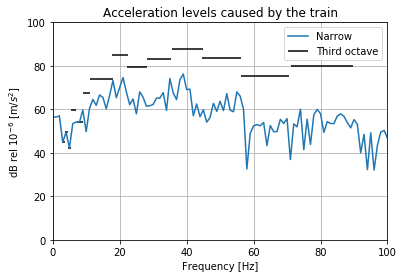

In [32]:
## Plot the the power spectrum of that chunk, narrowband and in 3rd octave bands
_, _, _, chunk_acc1, _ = obtain_greatest_rms_chunk(train_acc1_res, fft, fs = fs)
_, _, _, chunk_acc2, _ = obtain_greatest_rms_chunk(train_acc2_res, fft, fs = fs)

#Length of time series
chunk_length = chunk_acc1.shape[0]

#Calculate single sided FT accelerations
train_acc1_narrow = np.abs(make_single_sided(fft(chunk_acc1) / chunk_length))
train_acc2_narrow = np.abs(make_single_sided(fft(chunk_acc2) / chunk_length))

#Convert to third octave bands
train_acc1_3oct, _, _ = narrow_to_third(train_acc1_narrow, fs = fs)
train_acc2_3oct, _, _ = narrow_to_third(train_acc2_narrow, fs = fs)

#Frequency resolution and vector
df = fs / chunk_length
freq_vector_chunk = np.arange(0, fs / 2 , df)  #single sided  

#Generate plot
plt.figure(1)
plt.plot(freq_vector_chunk, 20 * np.log10((train_acc1_narrow) / ref_acc))
plt.hlines(20 * np.log10(train_acc1_3oct / ref_acc), lowlim_freq_3oct, uplim_freq_3oct)
plt.grid(b = True)
plt.title("Acceleration levels caused by the train")
plt.xlabel("Frequency [Hz]")
plt.ylabel("dB rel $10^{-6}$ [m/$s^{2}$]")
plt.legend(["Narrow", "Third octave"])
plt.xlim([0,100])
plt.ylim([0,100])

## Step C - Obtaining the Force Density Level (FDL)

Now that we have the LSTMs between the source and the measurement points, we can combine these LSTMs with the measured vibration levels, and obtain the different FDLs, which in theory should converge to one single curve. When everything goes right, they should differ in 1-2 dB.

C:\Users\coordinador\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
C:\Users\coordinador\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys
C:\Users\coordinador\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\coordinador\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in subtract
  


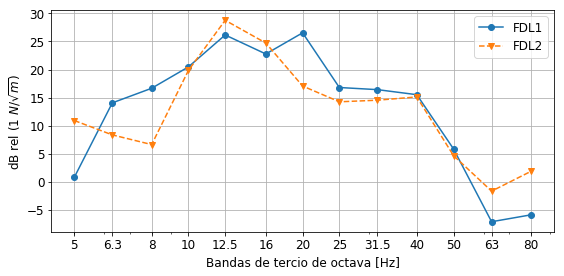

In [33]:
#Calculate FDL narrowband

FDL1_narrow = 20 * np.log10(train_acc1_narrow / ref_acc) - 20 * np.log10(LSTM_acc1_narrow / ref_LSTM)
FDL2_narrow = 20 * np.log10(train_acc2_narrow / ref_acc) - 20 * np.log10(LSTM_acc2_narrow / ref_LSTM)

#Calculate FDL in third octave bands
FDL1_3oct = 20 * np.log10(train_acc1_3oct / ref_acc) - 20 * np.log10(LSTM_acc1_3oct / ref_LSTM) 
FDL2_3oct = 20 * np.log10(train_acc2_3oct / ref_acc) - 20 * np.log10(LSTM_acc2_3oct / ref_LSTM) 

font = {'size'   : 12}
import matplotlib
matplotlib.rc('font', **font)

#Generate plot
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (8,4))
# ax1.hlines(FDL1_3oct, lowlim_freq_3oct, uplim_freq_3oct, label = "FDL1" )
# ax1.plot(freq_vector, FDL1_narrow, label = "FDL1")
# ax1.plot(freq_vector, FDL2_narrow, label = "FDL2", linestyle = "--")
ax1.plot(center_freq_3oct[7:], FDL1_3oct[7:], label = "FDL1", marker = "o")
ax1.plot(center_freq_3oct[7:], FDL2_3oct[7:], label = "FDL2", marker = "v", linestyle = "--")
ax1.grid(b = True)
ax1.set(xlabel = "Bandas de tercio de octava [Hz]" , ylabel = "dB rel (1 $N/\sqrt{m}$)")
plt.legend(loc='upper right')
plt.xscale("log")
# plt.xlim([5,100])
# plt.ylim([-5,45])
# ax1.set_xlim([6.3,80])
plt.xticks(center_freq_3oct[7:], center_freq_3oct[7:])
plt.tight_layout()


# PART 2: Making predictions

The objective of this part is to make the acceleration predictions at the prediction site for the eventual calculation (prediction) of the index __a<sub>W</sub>__. This part is divided in two steps: 
-  Step A - Estimating LSTM(d)<br>
-  Step B - Prediction of aw and eventually L<sub>aw</sub>

## Step A - Estimating LSTM(d)

In this step, the goal is to obtain, through regression, a LSTM function that varies with distance, i.e. to obtain LSTM(d). This is obtained, once we have obtained the LSTMs for the different accelerometeres, through regression of the different functions (graphs).

### Import data

C:\Users\coordinador\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\coordinador\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
C:/Users/coordinador/Desktop/Jupyter Notebooks/Modules\mi_modulo.py:759: RuntimeWarning: invalid value encountered in double_scalars
  y = (prediction_distance-LSTM1_distance)/(LSTM2_distance-LSTM1_distance) * (LSTMs[1][i] - LSTMs[0][i]) + LSTMs[0][i]


(0, 100)

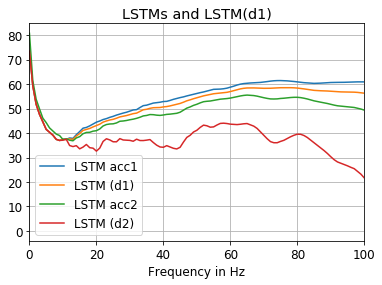

In [39]:
# In this case, the LSTMs are the ones that we have already used for the derivation of the FDL. 
# In a normal situation, the LSTMs of the prediction site should be obtained independently of the derivation of the FDL.
# To do that, it would be necessary to perform again the same calcualtions as in "Part1: Step A"

#Convert to dB (The posterior regressions need to be performed in dB to increase dynamic range)
LSTM_acc1_narrow_dB = 20 * np.log10(LSTM_acc1_narrow / ref_LSTM)
LSTM_acc2_narrow_dB = 20 * np.log10(LSTM_acc2_narrow / ref_LSTM)
LSTM_acc1_3oct_dB = 20 * np.log10(LSTM_acc1_3oct / ref_LSTM)
LSTM_acc2_3oct_dB = 20 * np.log10(LSTM_acc2_3oct / ref_LSTM)

#Obtain, through regression, the LSTMs(d). 
LSTM_d1_narrow_dB = regression_LSTM((LSTM_acc1_narrow_dB, LSTM_acc2_narrow_dB), LSTM1_distance = 3, LSTM2_distance = 8 , prediction_distance = 5)
LSTM_d1_3oct_dB = regression_LSTM((LSTM_acc1_3oct_dB, LSTM_acc2_3oct_dB), LSTM1_distance = 3, LSTM2_distance = 8 , prediction_distance = 5)

LSTM_d2_narrow_dB = regression_LSTM((LSTM_acc1_narrow_dB, LSTM_acc2_narrow_dB), LSTM1_distance = 3, LSTM2_distance = 8 , prediction_distance = 20)
LSTM_d2_3oct_dB = regression_LSTM((LSTM_acc1_3oct_dB, LSTM_acc2_3oct_dB), LSTM1_distance = 3, LSTM2_distance = 8 , prediction_distance = 20)


#Plot the LSTM(d) and the other two LSTMs

plt.plot(freq_vector, LSTM_acc1_narrow_dB, label = "LSTM acc1")
plt.plot(freq_vector, LSTM_d1_narrow_dB, label = "LSTM (d1)")
plt.plot(freq_vector, LSTM_acc2_narrow_dB, label = "LSTM acc2")
plt.plot(freq_vector, LSTM_d2_narrow_dB, label = "LSTM (d2)")
plt.legend()
plt.grid()
plt.xlabel("Frequency in Hz")
plt.title("LSTMs and LSTM(d1)")
plt.xlim([0,100])


## Step B - Prediction of L<sub>aw</sub>

In [65]:
#Calculate acceleration levels
La_narrow = FDL1_narrow + LSTM_d1_narrow_dB

#Undo the dB into m/s^2
array_of_tens = np.zeros(La_narrow.shape[0]) + 10
accel_narrow = np.power(array_of_tens, La_narrow / 20) * ref_acc

#Obtain the rms values for each third octave band
_,_, rms_values = narrow_to_third(accel_narrow, fs)

#Weighting factors para las center frequencies desde 1Hz a 80 Hz
weighting_factors = [0.833, 0.907, 0.934, 0.932, 0.910, 0.872, 0.818, 0.75, 0.669, 0.582, 0.494, 0.411, 0.337, 0.274, 0.22, 0.176, 0.14, 0.109, 0.0834, 0.0604]

#Weight it according to RD 1367/2007 
x = np.multiply(weighting_factors, rms_values)

#Obtain rms acceleration for each third-octave band and obtain aw
# a_w = np.sqrt(np.sum(np.square(x[np.isfinite(x)])))
a_w = np.sqrt(np.sum(np.square(x)))

#Calculate Law
Law =  20 * np.log10(a_w / ref_acc)

print(Law)

# print("The predicted Law with FDL1 and LSTM_d1 is", np.round(Law_1_1, decimals = 2), "dB")


70.44518852361838


### Verification measurements

In [27]:
#Import acceleration data of some train recorded signal
_, train_acc1_res, train_acc2_res = train4_data_import("Tren5_verificacion_dif_posicion.xlsx")
fs = 1024
train_acc1_res = librosa.core.resample(train_acc1_res.astype(np.float), orig_sr = 4096, target_sr = fs)
train_acc2_res = librosa.core.resample(train_acc2_res.astype(np.float), orig_sr = 4096, target_sr = fs)

start_sample, end_sample, chunk_ft_acc_values, chunk_signal, aw = obtain_greatest_rms_chunk(train_acc2_res, fft, fs = fs)

Law = 20 * np.log10(aw / ref_acc)
print("The Law of this signal is" , np.round(Law,decimals=2), "dB")

The Law of this signal is 72.82 dB


# RESULTS

Using FDL 1:

| Distance | Real L<sub>aw</sub> | Predicted L<sub>aw</sub> | Deviation |
| --- | --- | --- | --- |
| 5 m | 78 dB | 76 dB | 2 dB |
| 20 m | 74 dB | 69 dB | 5 dB |

Using FDL 2:

| Distance | Real L<sub>aw</sub> | Predicted L<sub>aw</sub> | Deviation |
| --- | --- | --- | --- |
| 5 m | 78 dB | 78 dB | 0 dB |
| 20 m | 74 dB | 69 dB | 5 dB |

### Aspectos a tener en cuenta y/o analizar

1. Los puntos de medida para la obtención de las dos LSTM se realizaron a 3 y 8 metros de la linea de impactos. Se observa menor desviación en la predicción a la distancia de 5 metros, ya que ésta se encuentra dentro de dicho intervalo. Sin embargo, al predecir a 20 metros, estamos asumiendo que desde los 8 metros hasta los 20 metros existe el mismo tipo de variación en la propagación que entre los 3 y los 8 metros, lo cual, muy probablemente, no sea cierto. <br><br>

2. Diferencias entre los dos FDL calculados. De dónde vienen estas diferencias? A partir de 8 Hz se observa bastante buena aproximación entre las dos (diferencias de entre 2 dB son totalmente esperables) <br><br>


## Correction to obtain the "real" approximated FDL from Valdemoro

In Valdemoro, the distance from the railway to the line of impacts was 19 m. Therefore, we cannot substract the measured LSTM from the La vibration levels to characterize the train-rail system because the LSTM is greater than what it should be (if it had been measured from the rail line to the measurement positions). Therefore, we need to extrapolate the LSTM (we measured at 3 and 8 meters from the line of impacts) to a distance of $19+3 = 22$ and $19+8 = 27$ meters.

C:/Users/coordinador/Desktop/Jupyter Notebooks/Modules\mi_modulo.py:696: RuntimeWarning: invalid value encountered in double_scalars
  y = (prediction_distance-LSTM1_distance)/(LSTM2_distance-LSTM1_distance) * (LSTMs[1][i] - LSTMs[0][i]) + LSTMs[0][i]
C:\Users\coordinador\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
C:\Users\coordinador\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


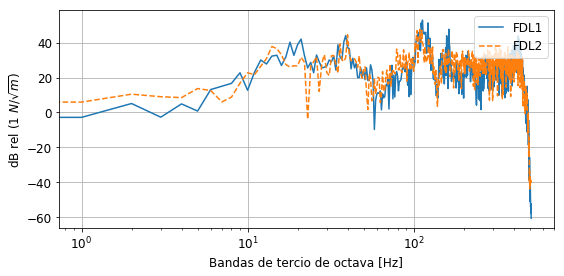

In [21]:
############# FDL CORREGIDO A LA DISTANCIA DE LA VÍA ######################
### ES NECESARIO CALCULAR PREVIAMENTE LSTM_d1_3oct_dB y LSTM_d2_3oct_dB #####
distancia_a_via = 19      #desde la posición de impacto

#Obtain, through regression, the LSTMs(d). 
LSTM_d1_narrow_dB_est = regression_LSTM((LSTM_acc1_narrow_dB, LSTM_acc2_narrow_dB), LSTM1_distance = 3, LSTM2_distance = 8 , prediction_distance = 3+distancia_a_via)
LSTM_d2_narrow_dB_est = regression_LSTM((LSTM_acc1_narrow_dB, LSTM_acc2_narrow_dB), LSTM1_distance = 3, LSTM2_distance = 8 , prediction_distance = 8+distancia_a_via)

LSTM_d1_3oct_dB_est = regression_LSTM((LSTM_acc1_3oct_dB, LSTM_acc2_3oct_dB), LSTM1_distance = 3, LSTM2_distance = 8 , prediction_distance = 3+distancia_a_via)
LSTM_d2_3oct_dB_est = regression_LSTM((LSTM_acc1_3oct_dB, LSTM_acc2_3oct_dB), LSTM1_distance = 3, LSTM2_distance = 8 , prediction_distance = 8+distancia_a_via)

#Correction for distance
FDL1_3oct_est = 20 * np.log10(train_acc1_3oct / ref_acc) - LSTM_d1_3oct_dB_est
FDL2_3oct_est = 20 * np.log10(train_acc2_3oct / ref_acc) - LSTM_d2_3oct_dB_est
FDL1_narrow_est = 20 * np.log10(train_acc1_narrow / ref_acc) - LSTM_d1_narrow_dB_est
FDL2_narrow_est = 20 * np.log10(train_acc2_narrow / ref_acc) - LSTM_d2_narrow_dB_est




#Generate plots

fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (8,4))
# ax1.hlines(FDL1_3oct, lowlim_freq_3oct, uplim_freq_3oct, label = "FDL1" )
# ax1.plot(center_freq_3oct[7:], FDL1_3oct_est[7:], label = "FDL1", marker = "o")
# ax1.plot(center_freq_3oct[7:], FDL2_3oct_est[7:], label = "FDL2", marker = "v", linestyle = "--")
ax1.plot(freq_vector, FDL1_narrow_est, label = "FDL1")
ax1.plot(freq_vector, FDL2_narrow_est, label = "FDL2", linestyle = "--")
ax1.grid(b = True)
ax1.set(xlabel = "Bandas de tercio de octava [Hz]" , ylabel = "dB rel (1 $N/\sqrt{m}$)")
plt.legend(loc='upper right')
plt.xscale("log")
# plt.xlim([1,100])
# plt.xticks(center_freq_3oct[7:], center_freq_3oct[7:])
plt.tight_layout()

In [22]:
#SAVE THEM
print(FDL1_narrow.shape)
np.save("FDL1_narrow_dB_Valdemoro_Corregido_distancia", FDL1_narrow_est)
np.save("FDL2_narrow_dB_Valdemoro_Corregido_distancia", FDL2_narrow_est)


(512,)


In [56]:
for i in range(0):
    print("a")